In [2]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# def prob2cls(pred):
#     cls = np.argmax(np.array(pred.split(','), dtype=float))
#     print(pred, cls)
#     return cls
def group_f1(df): 
    label = np.array(df.Class.tolist(), dtype=int)
    pred = np.argmax([np.array(i.split(','), dtype=float) for i in df.Pred.tolist()], axis=1)
    score = metrics.f1_score(label, pred, average='micro')
    return score

def group_kappa(df): 
    label = np.array(df.Class.tolist(), dtype=int)
    pred = np.argmax([np.array(i.split(','), dtype=float) for i in df.Pred.tolist()], axis=1)
    score = metrics.cohen_kappa_score(label, pred)
    return score

def group_acc(df): 
    label = np.array(df.Class.tolist(), dtype=int)
    pred = np.argmax([np.array(i.split(','), dtype=float) for i in df.Pred.tolist()], axis=1)
    score = metrics.accuracy_score(label, pred)
    return score

def group_auc(df): 
    label = np.array(df.Class.tolist(), dtype=int)
    pred = [np.array(i.split(','), dtype=float) for i in df.Pred.tolist()]
    # score = metrics.roc_auc_score(label, pred, multi_class='ovr', average='weighted', labels=[0, 1, 2, 3])
    score = metrics.roc_auc_score(label, pred, multi_class='ovr', average='macro', labels=[0, 1, 2, 3])
    
#     # calculate AUC one-by-one (same to the previous results)
#     lb = preprocessing.LabelBinarizer()
#     class_oh = lb.fit_transform(df.Class)
#     pred = [np.array(i.split(','), dtype=float) for i in df.Pred.tolist()]
#     pred_prob = np.array(pred)
#     # print(class_oh.shape, pred_prob.shape)
#     aucs = []
#     for c in range(4): 
#         fpr, tpr, thresh = metrics.roc_curve(class_oh[:, c], pred_prob[:, c])
#         aucs.append(metrics.roc_auc_score(class_oh[:, c], pred_prob[:, c]))

#     # calculate binary accuracy (AUC sometimes smaller than binary accuracy)
#     cls = df.Class.to_numpy()
#     class_oh = np.zeros((cls.size, 4))
#     class_oh[np.arange(cls.size), cls] = 1
#     pred = np.argmax([np.array(i.split(','), dtype=float) for i in df.Pred.tolist()], axis=1)
#     pred_oh = np.zeros((pred.size, 4))
#     pred_oh[np.arange(pred.size), pred] = 1
#     accs = []
#     for c in range(4):
#         print(class_oh[:, c].shape, pred_oh[:, c].shape)
#         accs.append(metrics.accuracy_score(class_oh[:, c], pred_oh[:, c]))
        
    return score#, np.mean(np.array(accs))#, np.mean(np.array(aucs))

## 1. Independent training

In [4]:
dfs = []
for mb in range(18): 
    for i in range(5):
        dfs.append(pd.read_csv('../results/molnet_chirality_cls_etkdg_csp{}-5fold_{}.csv'.format(str(mb), str(i)), 
                               sep='\t', index_col=0))
    df = pd.concat(dfs, ignore_index=True)
    
print('AUC:', df.groupby('MB').apply(group_auc), '\n')
print('ACC:', df.groupby('MB').apply(group_acc), '\n')
print('KAPPA:', df.groupby('MB').apply(group_kappa), '\n')
print('F1:', df.groupby('MB').apply(group_f1), '\n')

AUC: MB
0     0.903991
1     0.888175
2     0.888083
3     0.872263
4     0.878446
5     0.913602
6     0.810463
7     0.908732
8     0.754257
9     0.791005
10    0.799136
11    0.695836
12    0.842008
13    0.755476
14    0.827550
15    0.786620
16    0.840751
17    0.753723
dtype: float64 

ACC: MB
0     0.851724
1     0.767033
2     0.790541
3     0.746154
4     0.810861
5     0.803279
6     0.811686
7     0.858763
8     0.801403
9     0.829688
10    0.817316
11    0.774652
12    0.785030
13    0.782488
14    0.811200
15    0.888333
16    0.797826
17    0.728777
dtype: float64 

KAPPA: MB
0     0.746176
1     0.676322
2     0.693884
3     0.631509
4     0.692763
5     0.698252
6     0.651140
7     0.780697
8     0.596557
9     0.625047
10    0.635782
11    0.523861
12    0.658103
13    0.561908
14    0.655286
15    0.626344
16    0.670545
17    0.513777
dtype: float64 

F1: MB
0     0.851724
1     0.767033
2     0.790541
3     0.746154
4     0.810861
5     0.803279
6     0.811686
7

In [5]:
def process_prob(x): 
    x = np.array(x.split(','), dtype=float)
    return x

def plot_roc_curve(mb_idx, save_fig=False, print_confusion_metrics=False):
    lb = preprocessing.LabelBinarizer()
    if mb_idx == 'all':
        df_tmp = df
    else: 
        df_tmp = df[df['MB'] == mb_idx]
        
    class_oh = lb.fit_transform(df_tmp['Class'])
    pred_prob = df_tmp['Pred'].apply(process_prob)
    pred_prob = np.array(pred_prob.tolist())

    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9), gridspec_kw={'height_ratios': [0.6, 2]})

    sns.countplot(x=df_tmp["Class"], ax=ax1)

    for c in range(4): 
        fpr, tpr, thresh = metrics.roc_curve(class_oh[:, c], pred_prob[:, c])
        auc = metrics.roc_auc_score(class_oh[:, c], pred_prob[:, c])
        ax2.plot(fpr, tpr, label="class {} vs the rest (AUC={:.2f})".format(c, auc))

    ax2.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    ax2.axis("square")
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive Rate")
    ax2.set_title("One-vs-Rest ROC curves (encoded csp: {})".format(mb_idx))
    ax2.legend()

    plt.subplots_adjust(hspace=.3)
    if save_fig: 
        plt.savefig('./roc_curve_{}.png'.format(str(mb_idx)), dpi=300, bbox_inches='tight')
        print('Save!')
    plt.show()
    
    # confusion metrics
    if print_confusion_metrics: 
        pred = np.argmax(pred_prob, axis=1)
        print('confusion metrics: \n[[tn, fp], \n[fn, tp]]\n')
        print(metrics.multilabel_confusion_matrix(df_tmp['Class'].to_numpy(), pred))

Save!


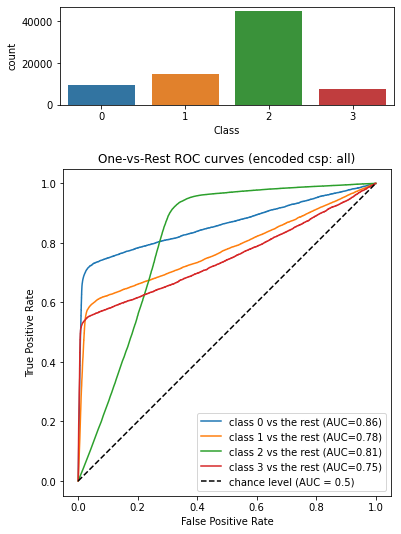

In [6]:
plot_roc_curve('all', save_fig=True)

Save!


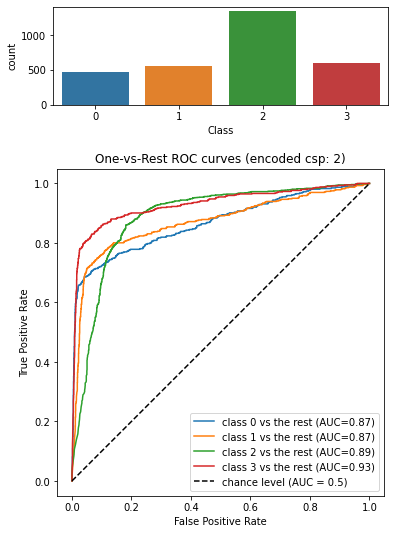

In [7]:
plot_roc_curve(2, save_fig=True)

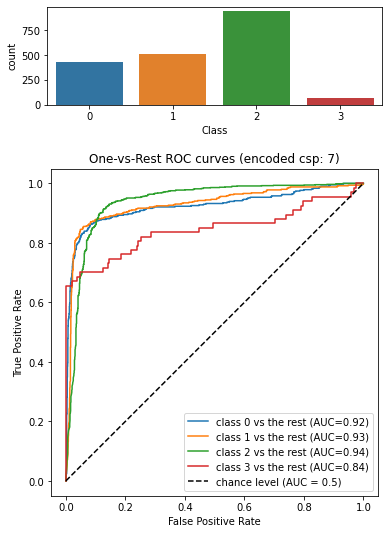

In [8]:
plot_roc_curve(7)

Save!


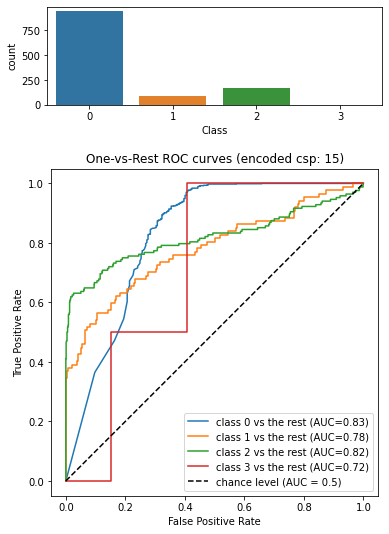

confusion metrics: 
[[tn, fp], 
[fn, tp]]

[[[ 143  114]
  [  11  932]]

 [[1111    2]
  [  57   30]]

 [[1014   18]
  [  64  104]]

 [[1198    0]
  [   2    0]]]


In [9]:
plot_roc_curve(15, save_fig=True, print_confusion_metrics=True)

## 2. Transfer learning

In [14]:
dfs = []
for mb in range(18): 
    for i in range(5):
        dfs.append(pd.read_csv('../results/molnet_chirality_cls_etkdg_csp{}-5fold_tl_{}.csv'.format(str(mb), str(i)), 
                               sep='\t', index_col=0))
    df = pd.concat(dfs, ignore_index=True)

In [17]:
# auc = df.groupby('MB').apply(group_auc)
acc = df.groupby('MB').apply(group_acc)
kappa = df.groupby('MB').apply(group_kappa)
f1 = df.groupby('MB').apply(group_f1)

In [18]:
# print('AUC:', '\n'+'\n'.join(auc.astype(str).tolist()), '\n')
print('ACC:', '\n'+'\n'.join(acc.astype(str).tolist()), '\n')
print('KAPPA:', '\n'+'\n'.join(kappa.astype(str).tolist()), '\n')
print('F1:', '\n'+'\n'.join(f1.astype(str).tolist()), '\n')

ACC: 
0.8724137931034482
0.7769230769230769
0.8050675675675676
0.7923076923076923
0.8299625468164794
0.8155737704918032
0.8349112426035503
0.8804123711340206
0.8129178704085844
0.8298828125
0.8406926406926407
0.8029643073200242
0.7868263473053893
0.8087557603686636
0.836
0.9083333333333333
0.7973913043478261
0.7359712230215827 

KAPPA: 
0.7805439870739794
0.6897213152201663
0.7145587536797406
0.6988369527531755
0.7239880266844818
0.7188911304775267
0.7005908482517142
0.8132661210857682
0.6229985001987868
0.6207329673551161
0.6799706052428681
0.5986985025813325
0.6664980046649441
0.617299889339727
0.70643595492231
0.7111508886486675
0.6704149610328269
0.5260983587673149 

F1: 
0.8724137931034482
0.7769230769230768
0.8050675675675676
0.7923076923076923
0.8299625468164794
0.8155737704918032
0.8349112426035503
0.8804123711340206
0.8129178704085845
0.8298828125
0.8406926406926407
0.8029643073200243
0.7868263473053893
0.8087557603686636
0.836
0.9083333333333333
0.7973913043478261
0.735971223

## ~~3. Multi-task training~~

In [8]:
df0 = pd.read_csv('../results/molnet_chirality_cls_etkdg_csp_multi_0.csv', sep='\t', index_col=0)

In [9]:
df0

,SMILES,MB,Class,Pred
0,CC(C)C[C@H](NC(=O)CNC(=O)c1ccc([N+](=O)[O-])cc...,5,2.0,"4.5605462219100446e-05,5.27926858922001e-05,0...."
1,N[C@H](c1ccc(Cl)cc1)c1c(O)ccc2ccccc12,8,3.0,"1.2610117664735299e-05,1.0384301276644692e-05,..."
2,COC(=O)/C(=C/c1ccccc1)C[C@H](N=C(c1ccccc1)c1cc...,4,2.0,"2.4754760943324072e-06,2.7021089863410452e-06,..."
3,CN1C(=O)[C@](F)(c2ccccc2F)c2ccccc21,8,2.0,"2.2476963295048336e-06,4.302982688386692e-06,0..."
4,O=C(O)[C@@H](O)c1ccccc1,11,2.0,"1.2974409401067533e-05,2.433597546769306e-05,0..."
...,...,...,...,...
15227,COc1cccc2c1CC[C@H](CCc1ccncc1)C2=O,12,3.0,"0.06194861978292465,0.931042492389679,0.002679..."
15228,C(=C/[C@@H](c1ccccc1)N1CCN(Cc2ccccc2)CC1)\c1cc...,8,1.0,"3.439827196416445e-06,1.552870344312396e-05,0...."
15229,CCCCC[C@H](O)C(Cl)(Cl)Cl,8,1.0,"0.00035614718217402697,0.9990562796592712,0.00..."
15230,O=C1C[C@H](c2ccccc2)Oc2ccc(O)cc21,15,0.0,"0.9980350136756897,0.00031149902497418225,0.00..."


In [10]:
# df0['Pred_cls'] = df0['Pred'].apply(prob2cls)

In [11]:
# df0

In [12]:
df0.groupby('MB').apply(group_auc)

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [ ]:
df0.groupby('MB').apply(group_acc)